# Kernel LR Model

In [17]:
import tensorflow as tf
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm_notebook

In [18]:
def predict(K, alpha):
    pred = np.dot(K,alpha)
    pred_proba = 1/(1+np.exp(-pred))
    pred = np.sign(pred)
    return pred

In [ ]:
def predict_proba(K, alpha):
    pred = np.dot(K,alpha)
    pred_proba = 1/(1+np.exp(-pred))
    return pred_proba

In [19]:
g1 = tf.Graph()
with g1.as_default():
    lam_tf = tf.placeholder(tf.float32)
    K_tf = tf.placeholder(tf.float32, [100, 100])
    y_tf = tf.placeholder(tf.float32, [100,1])

    alpha_tf = tf.Variable(tf.zeros((100,1)))

    logistic_loss = tf.reduce_mean(-tf.log_sigmoid(y_tf*tf.matmul(K_tf, alpha_tf)))
    reg_loss = 0.5*lam_tf*tf.matmul(tf.matmul(alpha_tf, K_tf, transpose_a = True),alpha_tf)
    loss = logistic_loss + reg_loss
    opt = tf.train.AdamOptimizer().minimize(loss)
    init = tf.initializers.global_variables()

In [20]:
g2 = tf.Graph()
with g2.as_default():
    lam_tf2 = tf.placeholder(tf.float32)
    K_tf2 = tf.placeholder(tf.float32, [99, 99])
    y_tf2 = tf.placeholder(tf.float32, [99,1])

    alpha_tf2 = tf.Variable(tf.zeros((99,1)))

    logistic_loss2 = tf.reduce_mean(-tf.log_sigmoid(y_tf2*tf.matmul(K_tf2, alpha_tf2)))
    reg_loss2 = 0.5*lam_tf2*tf.matmul(tf.matmul(alpha_tf2, K_tf2, transpose_a = True),alpha_tf2)
    loss2 = logistic_loss2 + reg_loss2
    opt2 = tf.train.AdamOptimizer().minimize(loss2)
    init2 = tf.initializers.global_variables()

In [21]:
def fit_model(K_train,y_train,lam,verbose=False):
    n = K_train.shape[0]
    
    tf.reset_default_graph()
    
    if n==100:
#         print("Graph 1")
        with tf.Session(graph=g1) as sess:
            sess.run(init)

            prevloss = np.inf
            c = 0
            while True:
                _,al,ll,rl, l = sess.run([opt, alpha_tf, logistic_loss, reg_loss, loss], 
                            feed_dict={K_tf: K_train, y_tf:y_train, lam_tf: lam})
                c += 1
                if abs((prevloss - l)/l) < 1e-4:
                    if verbose:
                        print("Iterations for convergence:",c, "Loss: ", l)
                    break
    #             if c%1000==0:
    #                 print(c, ll, rl, l, prevloss)

                prevloss = l
        
    if n==99:
#         print("Graph 2")

        with tf.Session(graph=g2) as sess:
            sess.run(init2)

            prevloss = np.inf
            c = 0
            while True:
                _,al,ll,rl, l = sess.run([opt2, alpha_tf2, logistic_loss2, reg_loss2, loss2], 
                            feed_dict={K_tf2: K_train, y_tf2:y_train, lam_tf2: lam})
                c += 1
                if abs((prevloss - l)/l) < 1e-4:
                    if verbose:
                        print("Iterations for convergence:",c, "Loss: ", l)
                    break
    #             if c%1000==0:
    #                 print(c, ll, rl, l, prevloss)

                prevloss = l
    
    return al
        
        

In [22]:
al = fit_model(K_train, y_train, lam, verbose=True)

Iterations for convergence: 973 Loss:  [[0.1664869]]


In [23]:
print(al.shape)
a = [(i,al[i]) for i in range(len(al))]
a.sort(key = lambda x: x[1], reverse=True)

(100, 1)


In [24]:
a[:10]

[(63, array([0.4906308], dtype=float32)),
 (55, array([0.4900435], dtype=float32)),
 (64, array([0.48284203], dtype=float32)),
 (65, array([0.43849814], dtype=float32)),
 (56, array([0.42166564], dtype=float32)),
 (73, array([0.4060342], dtype=float32)),
 (74, array([0.3869649], dtype=float32)),
 (54, array([0.38337046], dtype=float32)),
 (75, array([0.37316024], dtype=float32)),
 (66, array([0.3702452], dtype=float32))]

In [25]:
pred, _ = predict(K_train, al)
np.sum(pred != y_train)

1

# experiments

In [26]:
from sklearn.metrics import log_loss

In [27]:
def custom_log_loss(y_true, y_proba):
    return -np.mean(np.multiply(y_true, np.log(y_proba))+np.multiply(1-y_true, np.log(1-y_proba)))

In [29]:
def calculate_influences_on_trust_flip(X_train, y_train, X_trust, y_trust, gamma, lam):
    influences = []
    
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    K_trust = rbf_kernel(X_trust, X_train, gamma=gamma)
    alpha = fit_model(K, y_train, lam)
    
    pred, probas = predict(K, alpha)
    y_trust_pred, _ = predict(K_trust, alpha)
    
    l = []
    for i in range(len(y_trust)):
        if y_trust_pred[i] != y_trust[i]:
            pass
        l.append(i)
        
    X_trust_misclassified = X_trust[l]
    y_trust_misclassified = y_trust[l]
    K_trust_misclassified = K_trust[l]
    _, trust_misclassified_proba = predict(K_trust_misclassified, alpha)
    
    orig_loss = custom_log_loss(y_trust_misclassified, trust_misclassified_proba)
    
    for i in tqdm_notebook(range(X_train.shape[0])):
        y_train_mod = np.copy(y_train)
        y_train_mod[i] = 0 if (y_train_mod[i]==1) else 1 # flip single label
        
        alpha_ = fit_model(K, y_train_mod, lam)
        
        y_trust_pred,_ = predict(K_trust, alpha_)
        l = []
        for j in range(len(y_trust)):
            if y_trust_pred[j] != y_trust[j]:
                pass
            l.append(j)

        X_trust_misclassified = X_trust[l]
        y_trust_misclassified = y_trust[l]
        K_trust_misclassified = rbf_kernel(X_trust_misclassified, X_train, gamma=gamma)
        
        _, trust_misclassified_proba = predict(K_trust_misclassified, alpha_)
        mod_loss = custom_log_loss(y_trust_misclassified, trust_misclassified_proba)
        
#         print(y_trust[l],y_trust_misclassified,trust_misclassified_proba)
        
        influences.append((i, (orig_loss - mod_loss)))
                
    return influences

In [30]:
influences_flip_trust = calculate_influences_on_trust_flip(X_train, y_train, X_trust, y_trust, gamma, lam)

In [31]:
c = [(influences_flip_trust[i],X_train[i]) for i in range(len(influences_flip_trust))]
c.sort(key=lambda x:x[0][1], reverse=True)

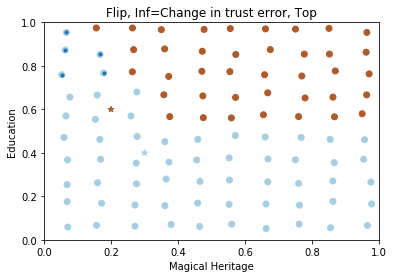

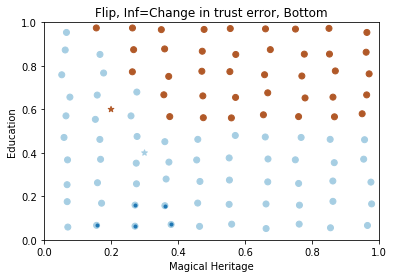

In [41]:
n = 5
top_n = True
visualize_top_influential_points(X_train, y_train, influences_flip_trust, n, top_n, X_trust, y_trust, title='Flip, Inf=Change in trust error, Top')
top_n = False
visualize_top_influential_points(X_train, y_train, influences_flip_trust, n, top_n, X_trust, y_trust, title='Flip, Inf=Change in trust error, Bottom')

# plotting

Plotting clusters...

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel

In [10]:
def visualize_top_influential_points(X_train, y_train, influences, n, top_n=True, X_trust=None, y_trust=None, title=None):
    if len(y_train.shape)==2:
        y_train = np.reshape(y_train,(y_train.shape[0],))
    
    
    influences.sort(key=lambda x:x[1], reverse=top_n)
    top_influence_indices = [i[0] for i in influences[:n]]
    
    top_influence_X = X_train[top_influence_indices,:]
    top_influence_y = y_train[top_influence_indices]
    
    plt.figure()
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker='o')
    
    plt.scatter(top_influence_X[:, 0], top_influence_X[:, 1], marker='.')
    
    if X_trust is not None:
        if len(y_trust.shape)==2:
            y_trust = np.reshape(y_trust,(y_trust.shape[0],))
        plt.scatter(X_trust[:, 0], X_trust[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='*')
    
    if title:
        plt.title(title)
    plt.xlabel('Magical Heritage')
    plt.ylabel('Education')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.draw()
    plt.show()

In [11]:
# ----------------------------------------
# For plotting data and decision boundary
def plot_model(X_train, y_train, clf, sigma, X_trust=None, y_trust=None, title=None, 
													train_cluster_labels=None, trust_cluster_labels=None):

	X = np.zeros((10000,2))
	a = np.linspace(0,1,100)
	b = np.linspace(0,1,100)
	e, d = np.meshgrid(a, b)
	X[:,0] = np.reshape(e,(10000,))
	X[:,1] = np.reshape(d,(10000,))

	K = rbf_kernel(X, X_train, gamma=(-1/(2.0*sigma**2)))
	Z = clf.predict(K)
	probs = clf.predict_proba(K)[:, 1].reshape(e.shape)

	plt.figure()

	# Put the result into a color plot
	Z = Z.reshape(e.shape)
	plt.contour(e, d, probs, levels=[0.5])

	# Plot clusters
	if train_cluster_labels is not None:
		if trust_cluster_labels is not None:
			cluster_labels = np.concatenate([train_cluster_labels,trust_cluster_labels])
			X = np.vstack([X_train, X_trust])
			plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, marker='o', s=80)
		else:
			plt.scatter(X_train[:, 0], X_train[:, 1], c=train_cluster_labels, marker='o', s=80)

	# Plot the training points
	plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker='.')
	
	# Plot the trusted points
	if X_trust is not None:
		plt.scatter(X_trust[:, 0], X_trust[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='X')

	if title is not None:
		plt.title(str(title))

	plt.xlabel('Magical Heritage')
	plt.ylabel('Education')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.draw()

# HarryPotter

In [1]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# for reproducibility, fix the random seed 
np.random.seed(123)

# the learner is hard coded to be kernel logistic regression.
# learner's parameters:
sigma = 0.4	# RBF kernel bandwidth
gamma = (1/(2.0*sigma**2))
lam = 1e-3

In [3]:
################### Harry Potter Toy Example ##################

# ----------------------------------------
# Generate "dirty" training data. 
# that is, we will plant some "historical bias" 
# in the form of labels: the Ministry of Magic refused to hire
# muggle-born graduates with high edcuation.

print("Creating training data...\n")

# Training Set size
n = 100 

# data points are on a uniform grid, then dithered with a Gaussian.
# x_1=magic heritage; x_2=education

X_train = np.zeros((n,2))
a = np.linspace(0.05, 0.95, num=int(np.sqrt(n)))
e, d = np.meshgrid(a, a)
X_train[:,0] = np.reshape(e,(n,))
X_train[:,1] = np.reshape(d,(n,))
X_train = X_train + 0.03*np.random.rand(n,2)

# the noiseless 'desired' label obeys y = sign(x_2 - 0.5)
y_clean = np.sign(X_train[:,1]-0.5)
y_clean = np.reshape(y_clean,(y_clean.shape[0],1))
# print(y_clean)

y_train = np.copy(y_clean)
y_train[(X_train[:,1]<(4*(X_train[:,0]-0.5)**2+0.5)) & (X_train[:,0]<0.5)] = -1
# print(y_train-y_clean)

Creating training data...



In [4]:
# --------------------------------------------------------------
# Generate trusted data
# we manually picked these two trusted items for pedagogical purpose
print("Creating trusted data...\n")

X_trust = np.array([[0.3, 0.4],[0.2, 0.6]])
y_trust = np.sign(X_trust[:,1]-0.5)
y_trust = np.reshape(y_trust,(y_trust.shape[0],1))
m = y_trust.shape[0]
c_value = 100  # Confidence parameters on trusted items are set to 100.
c = c_value*np.ones((m,1))

Creating trusted data...



In [5]:
# y[y==-1] = 0
# y_tilde[y_tilde==-1] = 0

In [6]:
print(X_train.shape, y_train.shape, X_trust.shape, y_trust.shape)

(100, 2) (100, 1) (2, 2) (2, 1)


In [7]:
K_train = rbf_kernel(X_train, X_train, gamma)
K_trust = rbf_kernel(X_trust, X_train, gamma)

In [8]:
print(K_train.shape,K_trust.shape)

(100, 100) (2, 100)
